## 导入包

In [11]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import math
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


In [12]:
# 导入训练集
train_data = pd.read_csv(r'C:\Users\Administrator\Desktop\Monthly Rent\train.csv',encoding="utf-8")
train_data=pd.DataFrame(train_data)

# 导入测试集，提取id
test_data = pd.read_csv(r'C:\Users\Administrator\Desktop\Monthly Rent\test.csv',encoding="utf-8")
test_data=pd.DataFrame(test_data)

In [13]:
#单独提取测试集ID
test_ID=test_data["id"]
test_data.drop("id",axis=1,inplace=True)

## 数据预处理

### 离群点处理

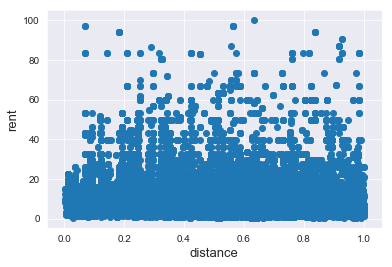

In [22]:
#忽略这部分
continuous_cols=['rent_quantity','total_floors','space','distance']

fig, ax = plt.subplots()
ax.scatter(x = train_data['distance'], y = train_data['rent'])
plt.ylabel('rent', fontsize=13)
plt.xlabel('distance', fontsize=13)
plt.show()

#### 房屋面积和租金的离群点处理

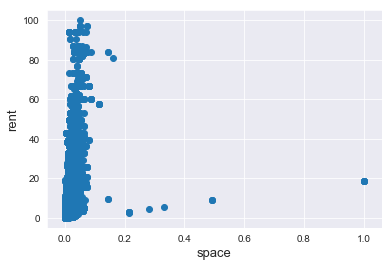

In [15]:
fig, ax = plt.subplots()
ax.scatter(x = train_data['space'], y = train_data['rent'])
plt.ylabel('rent', fontsize=13)
plt.xlabel('space', fontsize=13)
plt.show()

In [16]:
train_data=train_data.drop(train_data[(train_data['space']>0.2)].index)
train_data=train_data.drop(train_data[(train_data['space']>0.125) & (train_data['rent']<20)].index)

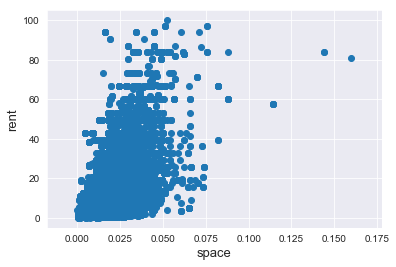

In [17]:
fig, ax = plt.subplots()
ax.scatter(x = train_data['space'], y = train_data['rent'])
plt.ylabel('rent', fontsize=13)
plt.xlabel('space', fontsize=13)
plt.show()

### 目标纠偏

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 7.95 and sigma = 6.31



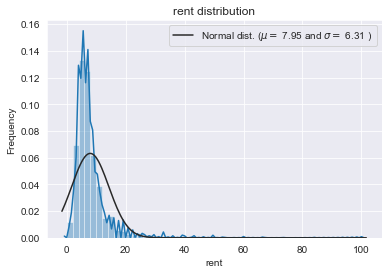

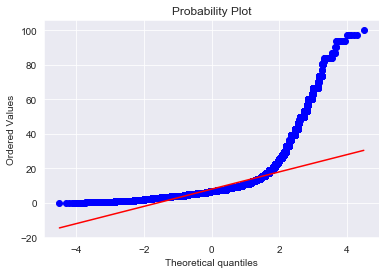

In [23]:
sns.distplot(train_data['rent'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['rent'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rent distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['rent'], plot=plt)
plt.show()

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 2.05 and sigma = 0.50



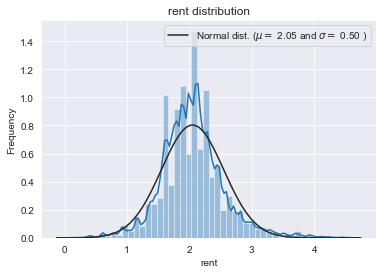

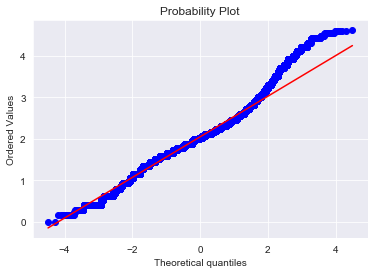

In [24]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column !!!!!!!!!!!!!!!!!!!!
train_data['rent'] = np.log1p(train_data['rent'])

#Check the new distribution 
sns.distplot(train_data['rent'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['rent'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rent distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['rent'], plot=plt)
plt.show()

### 特征工程

In [26]:
# 训练集测试集合并
ntrain = train_data.shape[0]  #训练集样本数
ntest = test_data.shape[0]  #测试集样本数
y_train = train_data.rent.values #训练集rent列
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['rent'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (252801, 18)


#### 缺失值

In [28]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
decoration situation,91.021001
state,90.260719
rent_style,88.449017
distance,53.218935
subway_station,53.218935
subway_line,53.218935
rent_quantity,0.404666
position,0.016218
area,0.016218


In [27]:
print(all_data.dtypes)
all_data.head(5)

time                         0
Cname                        0
rent_quantity             1023
floor                        0
total_floors                 0
space                        0
orientation                  0
state                   228180
bedroom_num                  0
hall_num                     0
toilet_num                   0
rent_style              223600
area                        41
position                    41
subway_line             134538
subway_station          134538
distance                134538
decoration situation    230102
dtype: int64
time                      int64
Cname                     int64
rent_quantity           float64
floor                     int64
total_floors            float64
space                   float64
orientation              object
state                   float64
bedroom_num               int64
hall_num                  int64
toilet_num                int64
rent_style              float64
area                    float64
position     

,time,Cname,rent_quantity,floor,total_floors,space,orientation,state,bedroom_num,hall_num,toilet_num,rent_style,area,position,subway_line,subway_station,distance,decoration situation
0,1,3072,0.128906,2,0.236364,0.008628,东南,NaN,1,1,1,NaN,11.0,118.0,2.0,40.0,0.764167,NaN
1,1,3152,0.132812,1,0.381818,0.017046,东,NaN,1,0,0,NaN,10.0,100.0,4.0,58.0,0.709167,NaN
2,1,5575,0.042969,0,0.290909,0.010593,东南,NaN,2,1,2,NaN,12.0,130.0,5.0,37.0,0.572500,NaN
3,1,3103,0.085938,2,0.581818,0.019199,南,NaN,3,2,2,NaN,7.0,90.0,2.0,63.0,0.658333,NaN
4,1,5182,0.214844,0,0.545455,0.010427,东北,NaN,2,1,1,NaN,3.0,31.0,NaN,NaN,NaN,NaN


In [45]:
cname_data = all_data["Cname"]
cname_data = set(cname_data)
for col in cname_data:
    print(all_data[all_data["Cname"] == col]['rent_quantity'].hasnull())

AttributeError: 'Series' object has no attribute 'hasnull'

In [ ]:
# 填补缺失值
# 小区租房数量（平均数）
mean_val = all_data["rent_quantity"].mean()
all_data["rent_quantity"] = all_data["rent_quantity"].fillna(mean_val)
# 区、位置（众数）
mode_area = all_data["area"].mode()
mode_position = all_data["position"].mode()
all_data["area"] = all_data["area"].fillna(int(mode_area))
all_data["position"] = all_data["position"].fillna(int(mode_position))